In [3]:
import requests         # 用來「發送網址請求」。
import pandas as pd      # Python表格處理工具。
import time           # 用來控制時間，主要是為了讓程式「暫停/睡覺」。
import re            # 正規表示式 (Regular Expression)，用來判斷輸入的是 "114/11" 還是 "100~114"。
from datetime import datetime # 用來抓現在電腦的時間 (避免抓取未來的月份)。

def get_twse_fmtqik(year, month):
    """
    抓取證交所每日市場成交資訊 (FMTQIK)
    year: 西元年 (int), month: 月份 (int)
    """
    # 1. 拼湊網址需要的日期格式。
    # 證交所 API 規定要 YYYYMMDD。雖然抓整月，但日期隨便填個 01 即可。
    # :02d 的意思是：如果是 1月，會自動補零變成 "01"。
    date_str = f"{year}{month:02d}01"

    # 2. 組合完整的網址
    url = f"https://www.twse.com.tw/rwd/zh/afterTrading/FMTQIK?response=json&date={date_str}"

    try: # try...except 是保護機制，怕網路斷線或證交所掛掉導致程式崩潰
        res = requests.get(url)  # 敲門，發送請求
        res_json = res.json()   # 把回傳的文字轉成 Python 看得懂的字典 (JSON 格式)

        # 3. 檢查證交所是否回應 "OK"
        if res_json['stat'] == 'OK':
            data = res_json['data']   # 這是真正的數據內容 (List of Lists)
            fields = res_json['fields'] # 這是欄位名稱 (日期、成交股數...)

            # 把原本亂亂的 List 轉成漂亮的 DataFrame 表格
            df = pd.DataFrame(data, columns=fields)
            return df
        else:
            # 如果是過年或是假日沒開盤的月份，可能會沒資料
            print(f"⚠️ {year}年{month}月 無資料或查詢失敗 ({res_json['stat']})")
            return None
    except Exception as e:
        # 如果發生預期外的錯誤 (如斷網)，印出錯誤訊息
        print(f"❌ {year}年{month}月 發生錯誤: {e}")
        return None
def parse_user_input(input_str):
    # 先把使用者可能輸入的 "年", "月", "空白" 都拿掉，只留數字跟符號
    input_str = input_str.replace("年", "").replace("月", "").replace(" ", "")

    # 【情況 1】輸入 "114/11" 或 "114.11"
    # re.match 是用來對圖形，r'...' 裡面是規則
    if re.match(r'^\d+[\/,\.]\d+$', input_str): # 要找一個字串，它的開頭(^)必須是一串數字(\d+)，中間夾著一個分隔符號([\/,\.])，後面緊接著另一串數字(\d+)，然後就結束($)，後面不能有雜訊。
        parts = re.split(r'[\/,\.]', input_str) # 用符號切開
        roc_year = int(parts[0])     # 前面是民國年
        month = int(parts[1])        # 後面是月份
        start_year = roc_year + 1911 # 轉西元
        return [(start_year, month)] # 回傳一個任務清單

    # 【情況 2】輸入 "100~114" 或 "100-114" (區間)
    elif re.match(r'^\d+[~-]\d+$', input_str):
        parts = re.split(r'[~-]', input_str)
        start_roc = int(parts[0])
        end_roc = int(parts[1])
        target_months = [] # 準備一個空的任務清單

        # 雙層迴圈：從 開始年 跑到 結束年
        for roc_y in range(start_roc, end_roc + 1):
            year = roc_y + 1911
            for m in range(1, 13): # 1月到12月
                # 檢查：如果是「今年」，且月份「大於現在月份」，就跳過 (未來還沒發生)
                if year == datetime.now().year and m > datetime.now().month:
                    continue
                target_months.append((year, m)) # 加入任務清單
        return target_months

    # 【情況 3】輸入 "114" (整年)
    elif re.match(r'^\d+$', input_str):
        roc_year = int(input_str)
        year = roc_year + 1911
        target_months = []
        for m in range(1, 13):
            # 同樣檢查是否為未來時間
            if year == datetime.now().year and m > datetime.now().month:
                continue
            target_months.append((year, m))
        return target_months

    else:
        return [] # 如果都對不上，回傳空清單表示輸入錯誤
# 1. 顯示說明並取得輸入
print("請輸入查詢區間 (民國年)...")
user_input = input("請輸入：")

# 2. 呼叫上面的大腦解析，得到任務清單 (task_list)
task_list = parse_user_input(user_input)

if not task_list:
    print("❌ 輸入格式錯誤...")
else:
    all_dfs = [] # 準備一個大籃子，裝每個月抓回來的表格
    print(f"🚀 開始抓取，共 {len(task_list)} 個月份資料...")

    # 3. 開始跑迴圈，一個月一個月抓
    for year, month in task_list:
        print(f"正在抓取: {year}年 {month}月...", end="\r") # end="\r" 讓文字在同一行更新，不會洗版
        df = get_twse_fmtqik(year, month) # 呼叫核心函式

        if df is not None:
            all_dfs.append(df) # 抓成功就丟進籃子

        # 保護機制
        # 如果不暫停，證交所會認為你是駭客攻擊 (DDoS)，會封鎖你的 IP。
        # 這裡設定睡 3.5 秒。
        if len(task_list) > 1:
            time.sleep(3.5)

    # 4. 資料整理與清洗
    if all_dfs:
        # concat 把籃子裡散落的月報表，上下接合變成一張大表
        final_df = pd.concat(all_dfs, ignore_index=True) # 忽略舊的index，改採用自動生成的index
        print("\n✅ 抓取完成！")

        # 處理數字格式問題：
        # 證交所給的數字都有千分位逗號 (例如 "1,000")，Python 會把它當文字。
        # 下面這段把逗號拿掉，並轉成數字 (numeric)。
        numeric_cols = ['成交股數', '成交金額', '成交筆數', '發行量加權股價指數', '漲跌點數'] # 這些欄位是我預期要轉成數字的
        # 篩選出真正存在的欄位 (避免有時候證交所欄位改名報錯)
        valid_cols = [c for c in numeric_cols if c in final_df.columns]
        # 請去檢查 numeric_cols 裡面的每一個名字（我們先叫它 c）。
        # 如果這個 c 真的存在於抓回來的資料表欄位 (final_df.columns) 裡，就把這個 c 留下來，放到新的清單 valid_cols 裡。

        for col in valid_cols:
            # astype(str): 先確保是文字
            # replace(',', ''): 拿掉逗號
            # pd.to_numeric: 轉成電腦可以運算的數字
            final_df[col] = final_df[col].astype(str).str.replace(',', '').apply(lambda x: pd.to_numeric(x, errors='coerce'))

        # 5. 顯示結果
        print(f"總筆數: {len(final_df)}")
        display(final_df.head()) # 看前五筆
        display(final_df.tail()) # 看後五筆

    else:
        print("\n⚠️ 未抓取到任何資料。")


請輸入查詢區間 (民國年)...
請輸入：95~115
🚀 開始抓取，共 241 個月份資料...
⚠️ 2009年5月 無資料或查詢失敗 (查詢日期小於79年1月4日，請重新查詢!)

✅ 抓取完成！
總筆數: 4913


,日期,成交股數,成交金額,成交筆數,發行量加權股價指數,漲跌點數
0,95/01/02,4697272274,116362497888,831039,6462.06,-86.28
1,95/01/03,5214136483,154358024475,993767,6591.77,129.71
2,95/01/04,5910064630,181449337758,1110682,6616.44,24.67
3,95/01/05,5851695431,166803758623,1088084,6709.87,93.43
4,95/01/06,5904757449,170640093669,1097763,6694.82,-15.05


,日期,成交股數,成交金額,成交筆數,發行量加權股價指數,漲跌點數
4908,115/01/14,11337766253,681983353722,4681743,30941.78,234.56
4909,115/01/15,11502671786,671953720007,4839771,30810.58,-131.20
4910,115/01/16,12754630286,851452408675,5392485,31408.70,598.12
4911,115/01/19,13668186807,823428003269,5907091,31639.29,230.59
4912,115/01/20,13170800649,799639371793,5725587,31759.99,120.70


In [4]:
import sqlite3
# 1. 確保 final_df 裡有「西元日期」且是正確的索引
# 如果您的 final_df 還沒有西元日期，先執行轉換
if '西元日期' not in final_df.columns and final_df.index.name != '西元日期':
    # 定義轉換函式 (如果之前定義過可以省略)
    def convert_roc_date_v2(date_str):
        try:
            parts = str(date_str).split('/')
            year = int(parts[0]) + 1911
            month = int(parts[1])
            day = int(parts[2])
            return pd.Timestamp(year=year, month=month, day=day)
        except:
            return pd.NaT

    # 建立西元日期欄位
    final_df['西元日期'] = final_df['日期'].apply(convert_roc_date_v2)
    # 設定為索引 (Index)
    final_df = final_df.set_index('西元日期')

# 2. 建立連結 (Connect)
# 如果檔案不存在，Python 會自動幫你在 Colab 裡生出一個 'stock_data.db' 檔案
conn = sqlite3.connect('stock_data.db')

# 3. 把整理好的 final_df 倒進去 (to_sql)
# name='twse_history': 這是在資料庫裡的「表單名稱 (Table Name)」
# conn: 剛剛建立的連結
# if_exists='replace': 如果表單已經存在，就「覆蓋」它。
# (註：如果是每天抓新資料，要改成 'append'，代表「附加」在後面)
# index=True: 因為我們的索引是「西元日期」，這很重要，所以要存進去
final_df.to_sql(name='twse_history', con=conn, if_exists='replace', index=True)

print("✅ 資料已成功存入 SQLite 資料庫！")
display(final_df.head(1))
# ==========================================
# 3. 驗證：試著用 SQL 語法把資料讀回來
# ==========================================
# 這是為了證明資料真的在裡面， SQL 指令：
# "SELECT * FROM twse_history WHERE 成交金額 > 8000億"

sql_query = "SELECT * FROM twse_history WHERE 成交金額 > 800000000000"
read_df = pd.read_sql(sql_query, conn)

print("\n=== 從資料庫撈出成交金額破 8000 億的日子 ===")
display(read_df)

conn.close()# 關閉連結

✅ 資料已成功存入 SQLite 資料庫！


,日期,成交股數,成交金額,成交筆數,發行量加權股價指數,漲跌點數
西元日期,,,,,,
2006-01-02,95/01/02,4697272274,116362497888,831039,6462.06,-86.28



=== 從資料庫撈出成交金額破 8000 億的日子 ===


,西元日期,日期,成交股數,成交金額,成交筆數,發行量加權股價指數,漲跌點數
0,2026-01-05 00:00:00,115/01/05,12257092861,800793653955,4932097,30105.04,755.23
1,2026-01-07 00:00:00,115/01/07,14251362877,881736707216,5538374,30435.47,-140.83
2,2026-01-16 00:00:00,115/01/16,12754630286,851452408675,5392485,31408.70,598.12
3,2026-01-19 00:00:00,115/01/19,13668186807,823428003269,5907091,31639.29,230.59


In [ ]:
# 存成 Excel 檔
# index=False 的意思是：不要把最左邊那排 0, 1, 2... 的索引數字存進去
final_df.to_excel("每日成交資訊.xlsx", index=False)

print("✅ Excel 檔案已建立！")

In [ ]:
# 存成 CSV 檔
# encoding='utf-8-sig' 是為了讓 Excel 開啟時中文不亂碼
final_df.to_csv("每日成交資訊.csv", index=False, encoding='utf-8-sig')

print("✅ CSV 檔案已建立！")

✅ CSV 檔案已建立！


In [5]:
import sqlite3
import pandas as pd

# 1. 建立連結 (Connect)
conn = sqlite3.connect('stock_data.db')

# 2. 撰寫 SQL 查詢語法 (Query)
# 從 'twse_history' 這張表單裡，把所有資料 (*) 都拿出來
sql_query = "SELECT * FROM twse_history"

# 3. 讀取資料 (Read SQL)
# index_col='西元日期': 告訴它哪一欄要當作最左邊的索引 (Index)
# parse_dates=['西元日期']: 告訴它這一欄是時間，請自動幫我轉成 datetime 格式
df = pd.read_sql(sql_query, conn, index_col='西元日期', parse_dates=['西元日期'])

# 4. 關閉連結 (Close)
# 避免資料庫被鎖死
conn.close()

# --- 檢查結果 ---
print("✅ 資料庫讀取成功！")
print(df.index.dtype) # 檢查索引是否真的是 datetime 格式
display(df.tail(3))

✅ 資料庫讀取成功！
datetime64[ns]


,日期,成交股數,成交金額,成交筆數,發行量加權股價指數,漲跌點數
西元日期,,,,,,
2026-01-16,115/01/16,12754630286,851452408675,5392485,31408.70,598.12
2026-01-19,115/01/19,13668186807,823428003269,5907091,31639.29,230.59
2026-01-20,115/01/20,13170800649,799639371793,5725587,31759.99,120.70


In [ ]:
# import (函式庫原本的名字) as (取的綽號)
import pandas as pd # Python 裡的 Excel
import matplotlib.pyplot as plt # Matplotlib (的 pyplot 模組)
import seaborn as sns # 美術設計

# 1. 讀取 CSV 檔案
# 注意：如果當初存檔有用 encoding='utf-8-sig'，讀取時建議也要加，避免亂碼
df = pd.read_csv("每日成交資訊.csv", encoding='utf-8-sig')


In [ ]:
# import (函式庫原本的名字) as (取的綽號)
import pandas as pd # Python 裡的 Excel
import matplotlib.pyplot as plt # Matplotlib (的 pyplot 模組)
import seaborn as sns # 美術設計
# 2. 資料清洗與還原 (因為 CSV 讀進來日期會變成純文字)
def convert_roc_date_v2(date_str):
  # def：關鍵字。告訴電腦「以下縮排的內容，都是屬於這個新功能的步驟」。
  # convert_roc_date_v2：函式名稱。這是您自己取的，就像幫新按鈕貼標籤。以後只要喊這個名字，Python 就會跑來執行這段。
  # (date_str)：參數 (Parameter)。這是「原料入口」。
  # 意思是：「想用這個功能，你必須丟給我一個東西，我暫時把它叫做 date_str。」
  # 在這個例子裡，原料就是 "114/01/01" 這種文字。
    try:
        # 處理民國年字串 "114/01/01" -> 西元 Timestamp
        parts = str(date_str).split('/') # 原料 "114/01/01" 遇到 / 就切一刀。變成三塊："114", "01", "01"。
        year = int(parts[0]) + 1911
        month = int(parts[1])
        day = int(parts[2])
        return pd.Timestamp(year=year, month=month, day=day)
    except:
        return pd.NaT

# 轉換日期欄位
df['西元日期'] = df['日期'].apply(convert_roc_date_v2)

# 設定索引 (畫圖用)
df = df.set_index('西元日期').sort_index()

# 確保數值欄位正確 (雖然 CSV 裡通常已經是數字，但為了保險再轉一次)
cols_to_plot = ['發行量加權股價指數', '成交金額', '成交股數', '成交筆數']
for col in cols_to_plot:
    # 這裡多做一個 replace 是怕萬一 CSV 裡還有逗號 errors='coerce':遇到看不懂的，不要報錯，強制把它變成 NaN
    df[col] = df[col].astype(str).str.replace(',', '').apply(lambda x: pd.to_numeric(x, errors='coerce')) # pd.to_numeric專門把東西轉成數字

print("✅ 資料讀取並還原完成！")
print(f"資料區間: {df.index.min().date()} 至 {df.index.max().date()}")
display(df.head(3))

✅ 資料讀取並還原完成！
資料區間: 2006-01-02 至 2026-01-20


,日期,成交股數,成交金額,成交筆數,發行量加權股價指數,漲跌點數
西元日期,,,,,,
2006-01-02,95/01/02,4697272274,116362497888,831039,6462.06,-86.28
2006-01-03,95/01/03,5214136483,154358024475,993767,6591.77,129.71
2006-01-04,95/01/04,5910064630,181449337758,1110682,6616.44,24.67


✅ 圖片已儲存為 stock_analysis_result.png


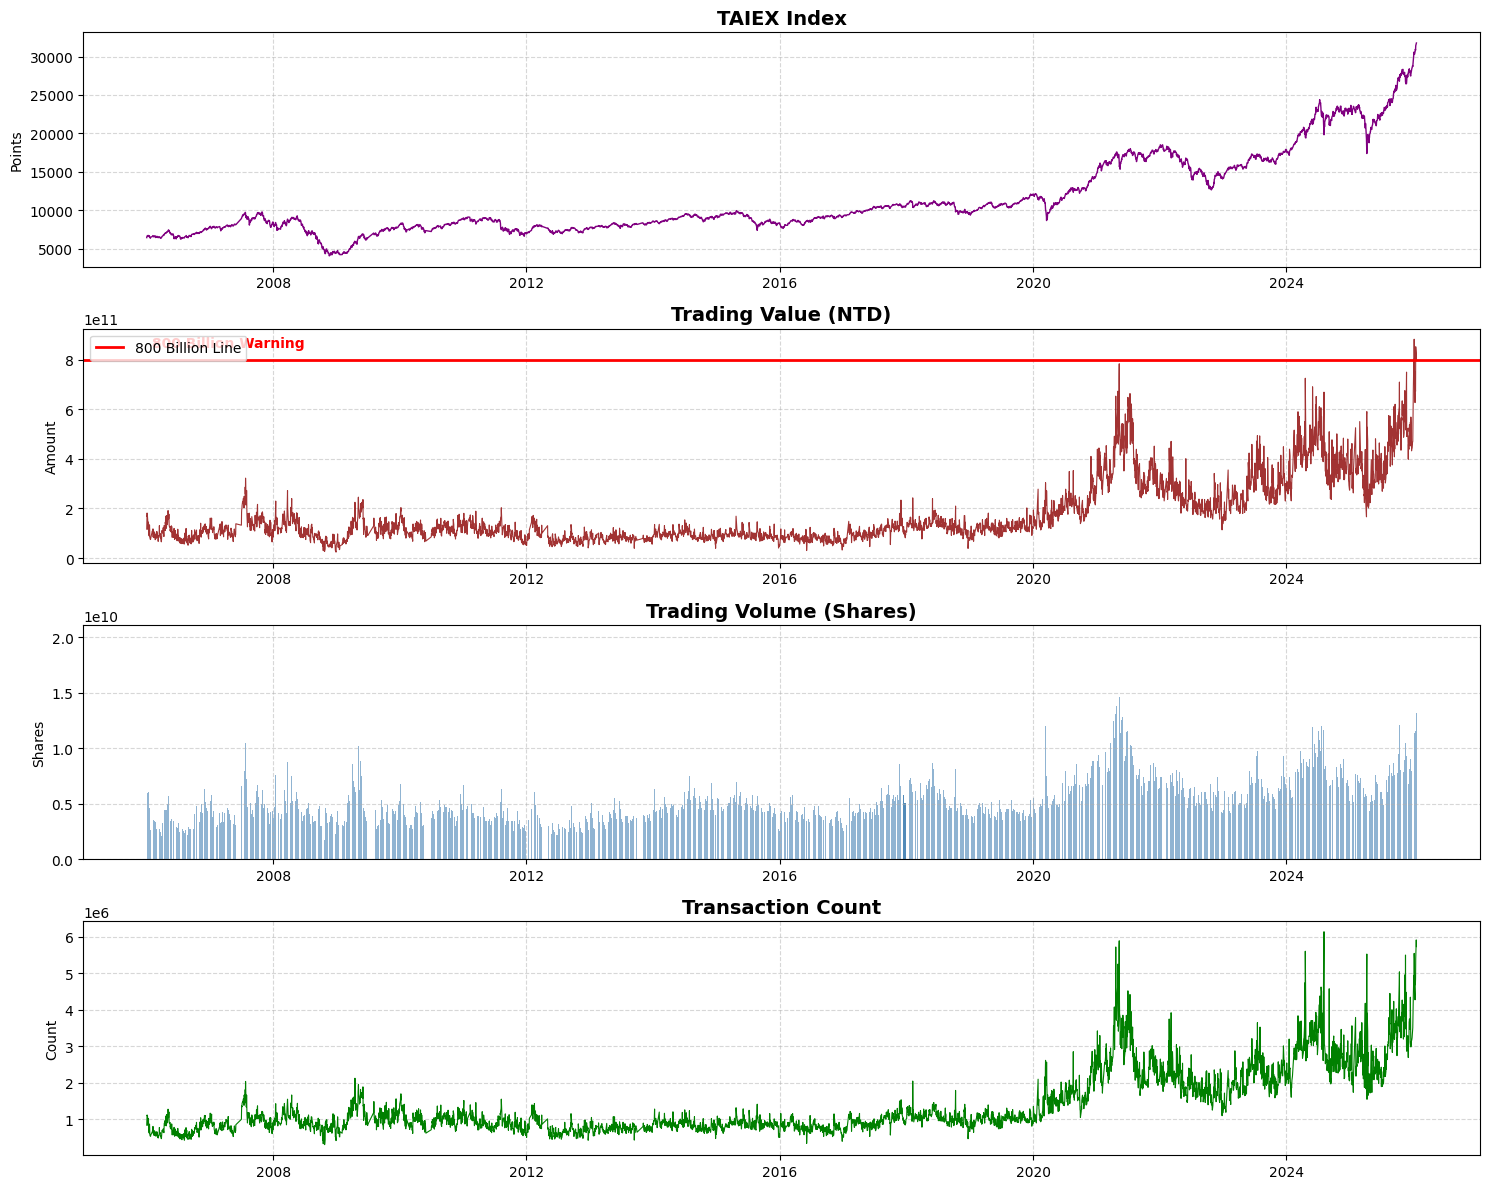

In [ ]:
# 設定畫布
plt.figure(figsize=(15, 12)) # (寬，高)

# --- 子圖 1: 加權指數 --- plt.subplot(總列數, 總行數, 第幾張)
ax1 = plt.subplot(4, 1, 1)
ax1.plot(df.index, df['發行量加權股價指數'], color='purple', linewidth=1)
ax1.set_title('TAIEX Index', fontsize=14, fontweight='bold')
ax1.set_ylabel('Points')
ax1.grid(True, linestyle='--', alpha=0.5) # 畫格子線對齊數字
                      # linestyle='--' (虛線), alpha=0.5 (透明度50%)

# --- 子圖 2: 成交金額 (含 8000億 警戒線) ---
ax2 = plt.subplot(4, 1, 2, sharex=ax1) # X 軸（時間軸）要跟 ax1 (第一層樓) 共用/連動
ax2.plot(df.index, df['成交金額'], color='darkred', linewidth=0.8, alpha=0.8)

# 畫警戒線 (8000億)
warning_val = 800_000_000_000
ax2.axhline(y=warning_val, color='red', linestyle='-', linewidth=2, label='800 Billion Line')

# 標註文字
ax2.text(df.index[0], warning_val * 1.05, ' 800 Billion Warning', color='red', fontweight='bold', va='bottom')
# df.index[0](X 軸位置)圖表的最左邊,warning_val * 1.05 (Y 軸位置)文字貼在「8000億」這條線的上方 5% 的位置。va='bottom' (垂直對齊)

ax2.set_title('Trading Value (NTD)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Amount')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend(loc='upper left')

# --- 子圖 3: 成交股數 ---
ax3 = plt.subplot(4, 1, 3, sharex=ax1)
ax3.bar(df.index, df['成交股數'], color='steelblue', alpha=0.6, width=1) # 長條圖bar
ax3.set_title('Trading Volume (Shares)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Shares')
ax3.grid(True, linestyle='--', alpha=0.5)

# --- 子圖 4: 成交筆數 ---
ax4 = plt.subplot(4, 1, 4, sharex=ax1)
ax4.plot(df.index, df['成交筆數'], color='green', linewidth=0.8)
ax4.set_title('Transaction Count', fontsize=14, fontweight='bold')
ax4.set_ylabel('Count')
ax4.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout() # 自動排版
# 存檔
# dpi=300: 解析度設高一點
plt.savefig('stock_analysis_result.png', dpi=300)
print("✅ 圖片已儲存為 stock_analysis_result.png")
plt.show()

✅ 圖片已儲存為 stock_analysis_result2.png


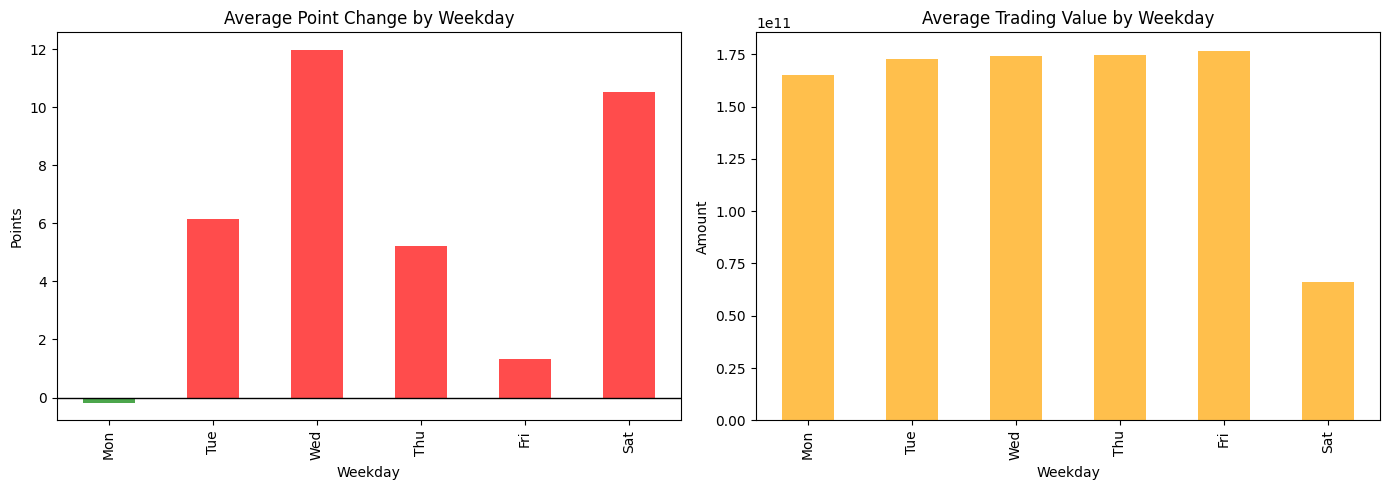

,漲跌點數,成交金額
Weekday,,
Mon,-0.178236,1.651896e+11
Tue,6.140519,1.725814e+11
Wed,11.967447,1.742795e+11
Thu,5.228598,1.746049e+11
Fri,1.323172,1.766226e+11
Sat,10.527273,6.593837e+10


In [ ]:
# 星期效應分析
# 新增一個「星期幾」的欄位 (0=週一, 1=週二 ... 4=週五)
df['Weekday'] = df.index.dayofweek # .dayofweek (這是時間機器人的內建功能，自動算出 0~6)
weekday_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat'} # 定義一個字典 (Dictionary)0~6對應,以前有週六開盤的歷史資料需考慮

# 計算所有星期幾的「平均漲跌點數」和「平均成交金額」,df.groupby('Weekday')：依'Weekday'(0~6)分成了5堆（週一堆、週二堆...）。
weekday_stats = df.groupby('Weekday')[['漲跌點數', '成交金額']].mean()

# 轉換索引名稱以便繪圖 .map(...) (翻譯動作)
weekday_stats.index = weekday_stats.index.map(weekday_map)

# 畫圖比較 1, 2：切成 1 列 2 行。ax：這次 ax 變成了一個清單，ax[0] 是左邊那張，ax[1] 是右邊那張。
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 左圖：平均漲跌點數
colors = ['green' if x < 0 else 'red' for x in weekday_stats['漲跌點數']] # 如果平均是跌的(x<0)給綠色，漲的給紅色
weekday_stats['漲跌點數'].plot(kind='bar', ax=ax[0], color=colors, alpha=0.7) # 畫長條圖 (kind='bar')
ax[0].axhline(0, color='black', linewidth=1) # 畫一條 0 的基準線
ax[0].set_title('Average Point Change by Weekday')
ax[0].set_ylabel('Points')

# 右圖：平均成交金額
weekday_stats['成交金額'].plot(kind='bar', ax=ax[1], color='orange', alpha=0.7)
ax[1].set_title('Average Trading Value by Weekday')
ax[1].set_ylabel('Amount')

plt.tight_layout()
# 存檔
plt.savefig('stock_analysis_result2.png', dpi=300)
print("✅ 圖片已儲存為 stock_analysis_result2.png")
plt.show()

display(weekday_stats)

=== 歷史數據顯示：平均下跌點數最多的日子 ===
Day
12   -9.884848
19   -9.593841
26   -8.529030
22   -5.432590
20   -2.749091
Name: 漲跌點數, dtype: float64
✅ 圖片已儲存為 stock_analysis_result3.png


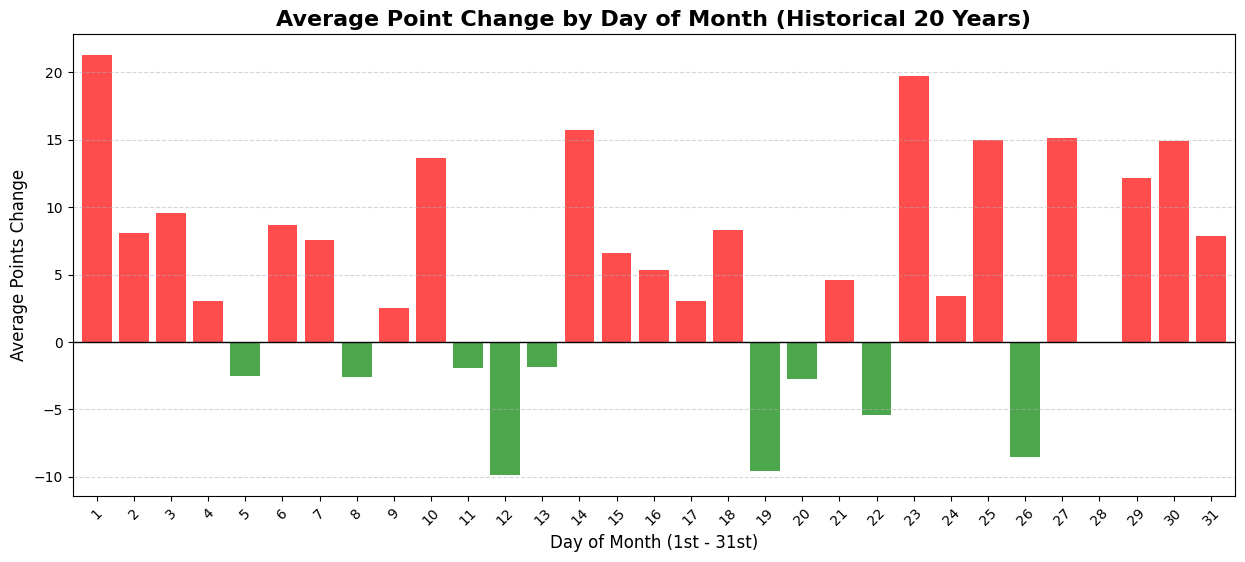

In [ ]:
# 日曆效應 (Calendar Effect)
# 1. 提取「日 (Day)」的資訊
# df.index 已經是 datetime 格式，直接 .day 就可以拿出它是幾號
df['Day'] = df.index.day

# 2. 分組運算：算出 1號~31號 每一天的平均漲跌點數
day_stats = df.groupby('Day')['漲跌點數'].mean()

# 3. 畫圖分析
plt.figure(figsize=(15, 6))

# 設定顏色：跌(負值)是綠色(便宜)，漲(正值)是紅色(貴)
colors = ['green' if x < 0 else 'red' for x in day_stats]

# 畫長條圖
day_stats.plot(kind='bar', color=colors, alpha=0.7, width=0.8)

# 加上 0 軸基準線
plt.axhline(0, color='black', linewidth=1)

# 設定標題與標籤
plt.title('Average Point Change by Day of Month (Historical 20 Years)', fontsize=16, fontweight='bold')
plt.xlabel('Day of Month (1st - 31st)', fontsize=12)
plt.ylabel('Average Points Change', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 標示出「最便宜」的前 3 名日子
sorted_days = day_stats.sort_values() # 由小(負最多)排到大
print("=== 歷史數據顯示：平均下跌點數最多的日子 ===")
print(sorted_days.head(5)) # 印出前 5 名
plt.xticks(rotation=45) # 代表X軸上的數字旋轉 45 度 (文字會直立起來)
# 存檔
plt.savefig('stock_analysis_result3.png', dpi=300)
print("✅ 圖片已儲存為 stock_analysis_result3.png")
plt.show()

✅ 圖片已儲存為 stock_analysis_result4.png


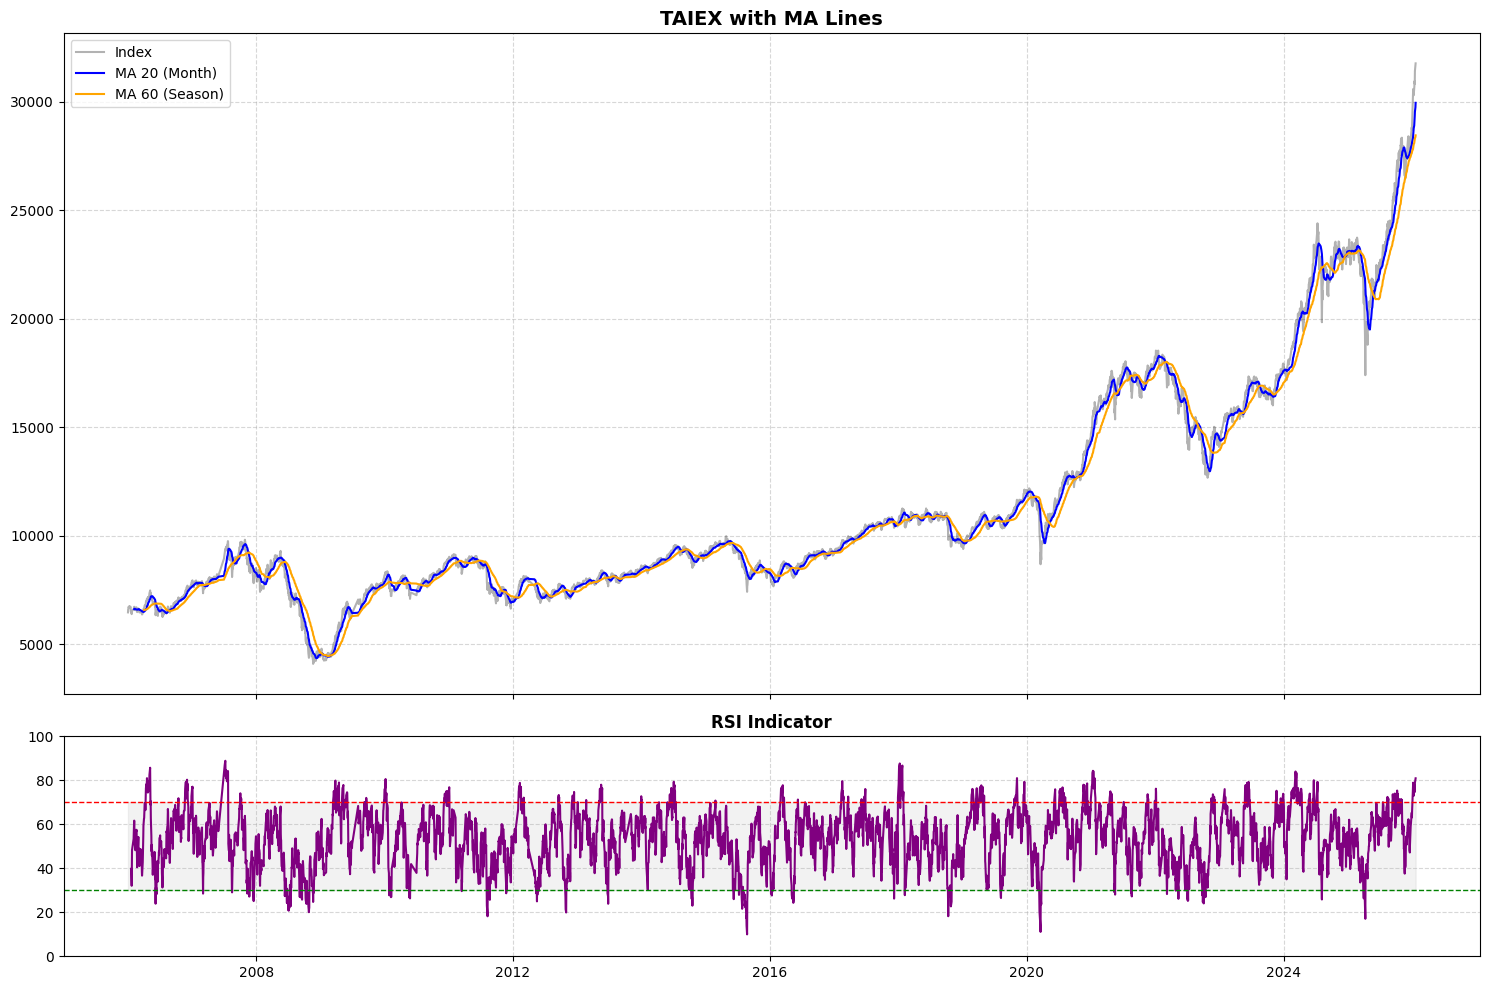

In [ ]:
# 移動平均線 (Moving Average, MA) & 相對強弱指標 (Relative Strength Index, RSI)
import pandas as pd
import matplotlib.pyplot as plt

# 為了確保計算正確，我們先把資料依照時間排序
df = df.sort_index()

# ==========================================
# 1. 計算 MA (移動平均線)
# ==========================================
# 邏輯：df['欄位'].rolling(視窗大小).mean()
# .rolling(20): 一個框框，一次框住20筆資料
# .mean(): 算出框框內的平均值

df['MA_20'] = df['發行量加權股價指數'].rolling(window=20).mean()
df['MA_60'] = df['發行量加權股價指數'].rolling(window=60).mean()

# ==========================================
# 2. 計算 RSI (相對強弱指標)
# ==========================================
# series「那一串股價」。這是一個代名詞。把 df['發行量加權股價指數'] 這一整欄資料丟進來，但在這個函式裡，暫時叫 series。
# period「天數週期」。算 RSI 需要決定看幾天的資料。RSI 的發明人威爾德(Wilder)建議用14天也是預設
def calculate_rsi(series, period=14):
    # 步驟 A: 算出每一天的「漲跌點數」
    # .diff(1) 今天減昨天 (Difference)即一階差分。
    delta = series.diff(1)

    # 步驟 B: 把漲的和跌的分開
    # clip(lower=0): Clip 是「修剪」把小於0的都變成0 -> 只留漲的 (Gain)
    # clip(upper=0): 把大於0的都變成0 -> 只留跌的，並取絕對值 (Loss)
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # 步驟 C: 算出平均漲幅與平均跌幅 (使用平滑移動平均 EMA)
    # alpha 是平滑係數，這是 RSI 的標準數學定義
    # .ewm(...)Exponential Weighted Moving Average (指數加權移動平均)越新的日子，權重越高，影響力越大
    avg_gain = gain.ewm(com=period-1, min_periods=period).mean() # com (Center of Mass, 質心) 設定為 天數 - 1。
    avg_loss = loss.ewm(com=period-1, min_periods=period).mean() # 最少要幾筆資料才算(14)

    # 步驟 D: 套公式
    # RS = 平均漲幅 / 平均跌幅
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 呼叫上面的函式來計算，並存入新欄位
df['RSI_14'] = calculate_rsi(df['發行量加權股價指數'])

# ==========================================
# 3. 畫圖驗證 (Price + MA + RSI)
# ==========================================
# 設定畫布：這次我們切成上下兩張圖 (2列1行)
# height_ratios=[3, 1]: 上面那張圖高度是下面的 3 倍 (因為主圖比較重要)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# --- 上圖：K線(這裡用收盤線代替) + MA ---
ax1.plot(df.index, df['發行量加權股價指數'], label='Index', color='black', alpha=0.3)
ax1.plot(df.index, df['MA_20'], label='MA 20 (Month)', color='blue', linewidth=1.5)
ax1.plot(df.index, df['MA_60'], label='MA 60 (Season)', color='orange', linewidth=1.5)
ax1.set_title('TAIEX with MA Lines', fontsize=14, fontweight='bold')
ax1.legend() # 顯示圖例 (Legend)
ax1.grid(True, linestyle='--', alpha=0.5)

# --- 下圖：RSI ---
ax2.plot(df.index, df['RSI_14'], label='RSI (14)', color='purple')
# 畫出 70 (超買) 和 30 (超賣) 的警戒線
ax2.axhline(70, color='red', linestyle='--', linewidth=1)
ax2.axhline(30, color='green', linestyle='--', linewidth=1)
# 塗滿中間區域 (美化用)
ax2.fill_between(df.index, 70, 30, color='gray', alpha=0.1)

ax2.set_title('RSI Indicator', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 100) # RSI 固定在 0~100
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
# 存檔
plt.savefig('stock_analysis_result4.png', dpi=300)
print("✅ 圖片已儲存為 stock_analysis_result4.png")
plt.show()